In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx
import scipy.spatial
import torch
import skimage.draw
from scipy.spatial import Delaunay 

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.seacast_tools.mesh_models.mesh_metrics as mm

In [10]:
def crosses_land(node1, node2, land_mask, threshold=8):
    x1, y1 = node1
    x2, y2 = node2
    rr, cc = skimage.draw.line(round(y1), round(x1), round(y2), round(x2))
    return np.sum(land_mask[rr, cc]) >= threshold

def add_diagonal_edges(nx, ny, g):
    """
    Add diagonal edges to a grid graph, where the graph neeeds to be a square uniform grid.
    The function iterates over the nodes in the grid and adds edges between diagonal nodes.

    Params:
    nx: number of nodes in x direction
    ny: number of nodes in y direction
    g: networkx graph object to which the diagonal edges will be added
    """
    for x in range(nx - 1):
        for y in range(ny - 1):
            if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
                g.add_edge((x, y), (x + 1, y + 1))
            if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
                g.add_edge((x + 1, y), (x, y + 1))

def add_Delaunay_edges(g):
    g.remove_edges_from(list(g.edges()))
    
    nodes_list = list(g.nodes())
    points = np.array([g.nodes[node]["pos"] for node in nodes_list])
    
    tri = scipy.spatial.Delaunay(points)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes_list[simplex[i]]
                node2 = nodes_list[simplex[j]]
                if g.has_node(node1) and g.has_node(node2):
                    g.add_edge(node1, node2)


def generate_random_nodes_positions(nx, ny, xm, xM, ym, yM):
    """ 
    Generate random nodes positions inside the mesh

    returns = list of coordinates (x,y) of the nodes to create a Graph with networkx
    """
    N = nx * ny
    lx = np.random.uniform(xm, xM, N)
    ly = np.random.uniform(ym, yM, N)
    secure_positions_within_the_limit(xm, xM, ym, yM, (xM - xm) / nx, (yM - ym) / ny, lx, ly)
    list_coords = []
    for x, y in zip(lx, ly):
        coord = (x, y)
        list_coords.append(coord)
    return list_coords



def generate_mesh_positions_with_random_offsets(nx, ny, lower_offset_bound, upper_offset_bound, xm, xM, ym, yM):
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx, dtype=np.float32)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny, dtype=np.float32)


    random_offset_x = np.random.uniform(lower_offset_bound, upper_offset_bound, len(lx))
    random_offset_y = np.random.uniform(lower_offset_bound, upper_offset_bound, len(ly))

    lx = lx + random_offset_x
    ly = ly + random_offset_y
    
    secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly)
    return lx,ly

def secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly):
    lx[0] = xm + dx / 2
    lx[-1] = xM - dx / 2

    for i in range(len(lx)):    
        if lx[i] < xm + dx / 2:
            lx[i] = xm + dx / 2
        if lx[i] > xM - dx / 2:
            lx[i] = xM - dx / 2
    
    ly[0] = ym + dy / 2
    ly[-1] = yM - dy / 2

    for i in range(len(ly)):
        if ly[i] < ym + dy / 2:
            ly[i] = ym + dy / 2
        if ly[i] > yM - dy / 2:
            ly[i] = yM - dy / 2

In [11]:
# -------------------------------
# Función para filtrar nodos cercanos (radio mínimo)
def enforce_minimum_distance(points, min_radius):
    """
    Filtra los puntos candidatos para asegurar que ninguno esté a una distancia menor a min_radius de otro.
    
    Args:
        points (np.ndarray): Array de puntos candidatos de forma (n, 2).
        min_radius (float): Distancia mínima permitida entre puntos.
        
    Returns:
        np.ndarray: Array de puntos aceptados.
    """
    accepted = []
    # Procesa los puntos en orden aleatorio
    indices = np.random.permutation(len(points))
    for idx in indices:
        pt = points[idx]
        if len(accepted) == 0:
            accepted.append(pt)
        else:
            accepted_arr = np.array(accepted)
            # Verifica que la distancia de pt a cada punto aceptado sea >= min_radius
            if np.all(np.linalg.norm(accepted_arr - pt, axis=1) >= min_radius):
                accepted.append(pt)
    return np.array(accepted)


def generate_mesh_positions_using_bathymetry(nx, ny, xm, xM, ym, yM, bathymetry):
    """
    Genera una lista de coordenadas (x,y) de los nodos para crear un Graph con networkx.
    Usa los datos de batimetría para generar una distribución de probabilidad y seleccionar
    posiciones ponderadas. Además, se asegura de que los nodos no estén muy próximos entre sí
    y se encuentren dentro de los límites del mesh.
    
    Parámetros:
        nx, ny: número de nodos en las direcciones x e y (útiles para calcular total de nodos)
        xm, xM: límites en x
        ym, yM: límites en y
        bathymetry: array 2D (por ejemplo, cargado de un archivo .npy) con valores de profundidad, 
                    donde 0 es tierra y >0 es mar.
                    
    Retorna:
        Lista de coordenadas (x,y) (como tuplas) para crear el grafo.
    """
    import numpy as np
    
    np.random.seed(42)
    total_nodes_to_generate = nx * ny
    #Create a grid of coordinates based on the bathymetry shape
    # this will be used to get the coordinates of the points to be generated
    x = np.linspace(xm, xM, bathymetry.shape[0])
    y = np.linspace(ym, yM, bathymetry.shape[1])
    X, Y = np.meshgrid(x, y)
    # Aplanamos la batimetría y seleccionamos los puntos válidos (donde hay mar, > 0)
    epsilon = 1e-3
    # If bathymetry is 0, we set density to 0.0, otherwise we set it to 1.0/(bathymetry + epsilon)
    # with the inverse, we try to give more "importance" to the shallow areas (where bathymetry is small)
    # We add epsilon to avoid division by zero and to ensure that the density is not infinite as a safeguard.
    density = np.where(bathymetry > 0, 1.0 / (bathymetry + epsilon), 0)
    p = density / np.sum(density)  # Normalizar para obtener distribución de probabilidad
    
    indices = np.random.choice(np.arange(bathymetry.shape[0]*bathymetry.shape[1]), size=total_nodes_to_generate, replace=False, p=p.ravel())
    selected_x = X.ravel()[indices]
    selected_y = Y.ravel()[indices]
    candidate_points = np.vstack([selected_x, selected_y]).T
    
    ## Usamos las dimensiones reales de la matriz de batimetría para generar el grid de coordenadas
    #filas, columnas = bathymetry.shape
    ## Se generan los arrays de coordenadas para cada celda de la matriz batimetría,
    ## garantizando que tengan longitud igual a filas*columnas.
    #x_all = np.tile(np.linspace(xm, xM, columnas), filas)
    #y_all = np.repeat(np.linspace(ym, yM, filas), columnas)
    #
    ## Extraemos las coordenadas correspondientes a los índices seleccionados
    #lx = x_all[random_indices]
    #ly = y_all[random_indices]
    # Se asegura que las posiciones estén dentro de los límites (se asume que secure_positions_within_the_limit está definida)
    secure_positions_within_the_limit(xm, xM, ym, yM, (xM - xm) / nx, (yM - ym) / ny, selected_x, selected_y)
    
    # Se establece una distancia mínima entre nodos basada en la proporción de nodos
    nodes_proportion = bathymetry.shape[0] * bathymetry.shape[1] / total_nodes_to_generate
    min_distance = establish_min_distance_between_nodes(nodes_proportion)
    print(min_distance)
    # Se filtran los puntos para que ninguno esté muy cerca de otro
    filtered_points = enforce_minimum_distance(candidate_points, min_distance)
    #filtered_points = candidate_points
    # Convertimos a lista de tuplas
    list_coords = [tuple(coord) for coord in filtered_points]
    return list_coords

def establish_min_distance_between_nodes(nodes_proportion):
    proportion_as_a_square = nodes_proportion/4
    proportion_as_a_circle_radius = proportion_as_a_square/2
    proportion_as_a_circle_area = np.pi * (proportion_as_a_circle_radius**2)
    min_distance = (np.sqrt(proportion_as_a_circle_area / nodes_proportion)) +1
    print("min_distance", min_distance)
    return min_distance

In [12]:
def mk_2d_non_uniform_graph(xy, nx, ny, land_mask, sea_depth):
    """
    Create a 2D non-uniform graph using networkx where:
    - The function takes a mesh grid defined by the xy coordinates and the number of nodes in x and y direction.
    - The function generates positions for the nodes inside the mesh.
    - The function ensures that the positions of the nodes are not too close to each other by setting a minimum distance between them.
    - The function also ensures that the positions of the nodes are within the limits of the mesh.
    - The function ensures that the nodes are not placed on land by checking the land mask.
    - The function adds edges to the graph based on the Delaunay triangulation of the nodes.

    Params:
    xy: mesh grid coordinates
    nx, ny: number of nodes in x and y direction
    land_mask: mask of land nodes
    lower_offset_bound: lower bound for random offsets
    upper_offset_bound: upper bound for random offsets
    mode: mode of generation, either "random_offsets" or "random"

    returns:
    - dg: directed graph with nodes and edges
    """

    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    list_coords = generate_mesh_positions_using_bathymetry(nx, ny, xm, xM, ym, yM, sea_depth)

    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if dist < np.sqrt(0.5):
            g.remove_node(node)
        else:
            g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg

In [13]:
dataset = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic"
static_dir_path = os.path.join(dataset, "static")
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))
sea_depth = np.load(os.path.join(static_dir_path, "sea_depth.npy"))
land_mask = ~sea_mask[0]
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))
temperature_of_one_day = np.load(os.path.join(dataset, "raw", "reanalysis", "20180101.npy"))
temperature_of_second_day = np.load(os.path.join(dataset, "raw", "reanalysis", "20180102.npy"))
temp_values = temperature_of_one_day.flatten()

# 2. Obtener el mask 2D (ya que sea_mask tiene una dimensión extra)
mask2d = sea_mask[0]  # Ahora mask2d tiene forma (300, 300)

# 3. Crear un grid lleno de ceros con la forma (300, 300)
temp_grid = np.zeros(mask2d.shape, dtype=temperature_of_one_day.dtype)

# 4. Asignar los valores de temp_values en las posiciones donde mask2d es True
temp_grid[mask2d] = temp_values

print("temp_grid", temp_grid)

temp_grid [[295.16 295.16 295.16 ...   0.     0.     0.  ]
 [295.09 295.11 295.1  ...   0.     0.     0.  ]
 [295.02 295.05 295.05 ...   0.     0.     0.  ]
 ...
 [293.24 293.35 293.38 ...   0.     0.     0.  ]
 [293.2  293.32 293.36 ...   0.     0.     0.  ]
 [293.21 293.29 293.32 ...   0.     0.     0.  ]]


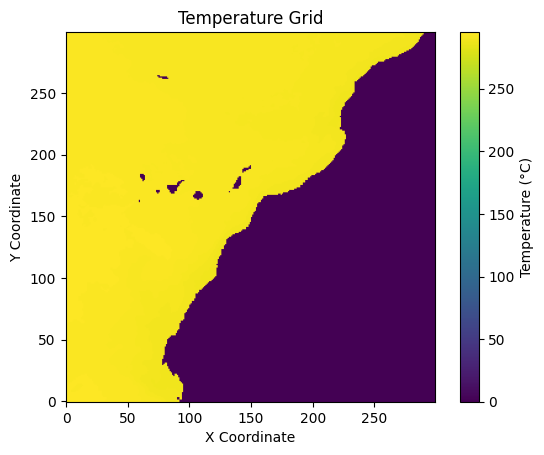

In [14]:
#plot temp_grid
plt.imshow(temp_grid, cmap='viridis', origin='lower')
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()



In [15]:
def normalize_temperature_data_and_convert_to_grid(temperature_of_one_day, sea_mask):
    #normalize to 0-1
    #formula = (x - min) / (max - min)
    numerator = (temperature_of_one_day - temperature_of_one_day.min())
    denominator = (temperature_of_one_day.max() - temperature_of_one_day.min())
    temperature_of_one_day_norm = numerator / denominator

    temp_values_norm = temperature_of_one_day_norm.flatten()

# 2. Obtener el mask 2D (ya que sea_mask tiene una dimensión extra)
    mask2d = sea_mask[0]  # Ahora mask2d tiene forma (300, 300)

# 3. Crear un grid lleno de ceros con la forma (300, 300)
    temp_grid_norm = np.zeros(mask2d.shape, dtype=temperature_of_one_day.dtype)

# 4. Asignar los valores de temp_values en las posiciones donde mask2d es True
    temp_grid_norm[mask2d] = temp_values_norm
    return temp_grid_norm

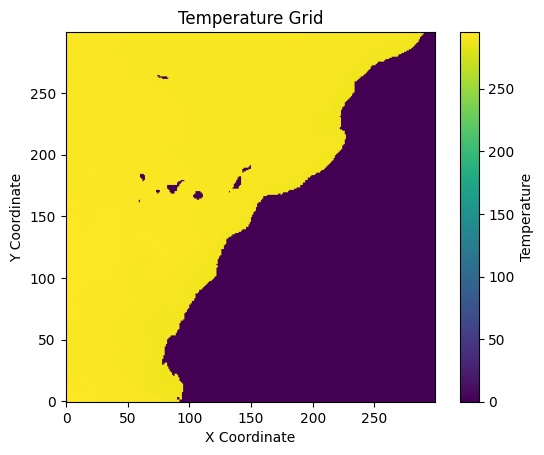

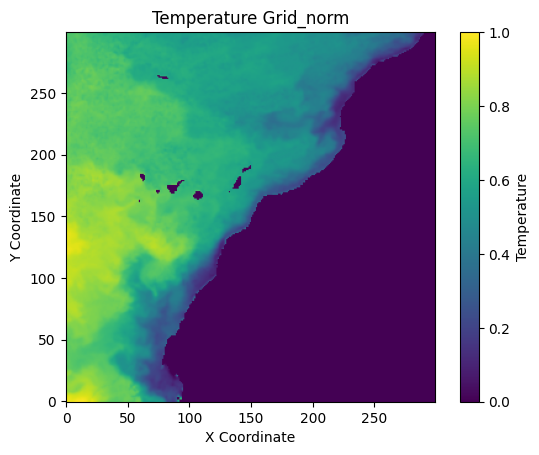

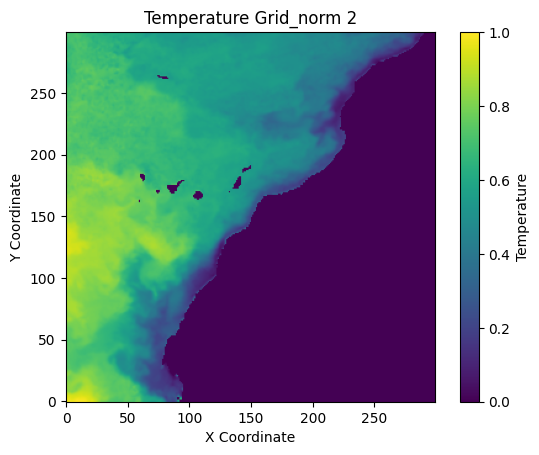

In [22]:
temp_grid_norm = normalize_temperature_data_and_convert_to_grid(temperature_of_one_day, sea_mask)
temp_grid_norm2 = normalize_temperature_data_and_convert_to_grid(temperature_of_second_day, sea_mask)
#plot sea_depth
plt.imshow(temp_grid, cmap='viridis', origin='lower')
plt.colorbar(label='Temperature')
plt.title('Temperature Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

plt.imshow(temp_grid_norm, cmap='viridis', origin='lower')
plt.colorbar(label='Temperature')
plt.title('Temperature Grid_norm')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

plt.imshow(temp_grid_norm2, cmap='viridis', origin='lower')
plt.colorbar(label='Temperature')
plt.title('Temperature Grid_norm 2')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Si generamos la malla con la temperatura, ¿Se debería aumentar el peso en las zonas de mayor o menor temperatura? 

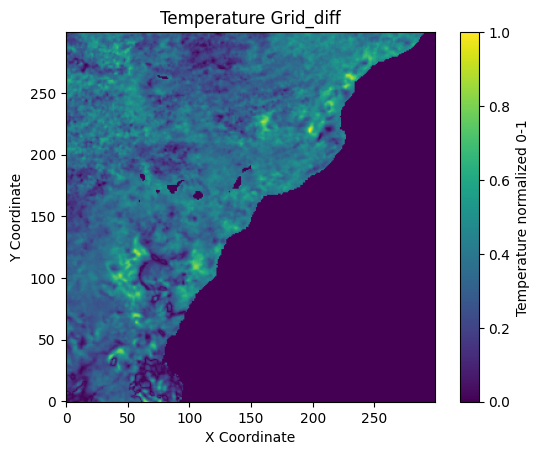

In [23]:
#calculate absolute difference between the two days
temp_diff = np.abs(temp_grid_norm - temp_grid_norm2)

#normmalize to 0-1
numerator = (temp_diff - temp_diff.min())
denominator = (temp_diff.max() - temp_diff.min())
temp_diff_norm = numerator / denominator


#plot
plt.imshow(temp_diff_norm, cmap='viridis', origin='lower')
plt.colorbar(label='Temperature normalized 0-1')
plt.title('Temperature Grid_diff')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()



Si generamos a partir de diferencias de temperatura, se pueden presentar varias opciones:
- Diferencias de temperatura del día anterior y el actual
- Diferencias de temperatura mes a mes (o según franja de tiempo)
- Hacer diferencias de temperatura día a día (o unidad de tiempo deseada) donde en vez de ser el anterior, comparar la unidad de tiempo anterior con una acumulada anterior.

Otro apunte importante puede venir dado de la mano de cómo hacer la diferencias de temperatura, ya que si se quiere captar y premiar las zonas donde sube o baja la temperatura, supondría hacer una resta sin el absoluto y asegurar el orden de los operandos. 

Si solo se quiere saber si cambia la temperatura y cuanto, se puede hacer una resta con el absoluto para captar el cambio sin importar el signo y solo tener una medida de cambio.